In [1]:
import tensorflow as tf
import os
import pandas as pd

from assets.one_mask.data_generator_new import DR_Generator
from assets.one_mask.models import SMD_Unet 
from assets.one_mask.trainer_withCE import Trainer

ma_df = pd.read_csv('../data/mask_analysis.csv')
ma_df = ma_df.fillna('x')

file_names = list(ma_df['file_name'].values)

tr_file_names = file_names[:1108]
val_file_names = file_names[1108:1660]
ts_file_names = file_names[1660:1840]

# 심각하게 넓게 잡힌 애들
useless_1 = ma_df[ma_df['넒게 잡힘'] == 'ㅇ(심각)']['file_name'].values

# 실제론 있는데 마스크가 안잡혀있는 애들
cond1 = ma_df['안잡힘'] == 'ㅇ';cond2 = ma_df['덜잡힘'] == 'ㅇ'
useless_2 = ma_df[cond1 & cond2]['file_name'].values

useless_files = []
useless_files.extend(useless_1)
useless_files.extend(useless_2)

tr_file_names = [file for file in tr_file_names if file not in useless_files]
val_file_names = [file for file in val_file_names if file not in useless_files]
ts_file_names = [file for file in ts_file_names if file not in useless_files]

In [2]:
masks = ['HardExudate_Masks', 'Hemohedge_Masks', 'Microaneurysms_Masks', 'SoftExudate_Masks']
mask_dir = '../data/FGADR/Seg-set'
mask_paths = [os.path.join(mask_dir, mask) for mask in masks]

generator_args = {
    'dir_path':'../data/FGADR/Seg-set/Original_Images/',
    'mask_path':mask_paths,
    'use_mask':True,
    'img_size':(512, 512),  
    'batch_size':4, # 8로 하면 바로 OOM 뜸
    'dataset':'FGADR', # FGADR or EyePacks
    'use_3channel':True,
    'CLAHE_args':None
}

tr_fgadr_gen = DR_Generator(is_train=True, file_names=tr_file_names,  **generator_args)
val_fgadr_gen = DR_Generator(is_train=False, file_names=val_file_names, **generator_args)
ts_fgadr_gen = DR_Generator(is_train=False, file_names=ts_file_names, **generator_args)

In [3]:
model = SMD_Unet(enc_filters=[64, 128, 256, 512, 1024], dec_filters=[512, 256, 64, 32], input_channel=3)
# model.load_weights("../models/one_mask/New/9_CLAHE_CE/20")

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001) 

trainer_args = {
    'model':model,
    'epochs':50,
    'optimizer':optimizer,
    'for_recons':False,   # pretraining을 할지 말지 (true = recons만 학습 한다.)
    'alpha':0.1,           # loss를 구할때 mask_loss는 알파 * recons_loss + (1 - 알파 * mask_loss)
    'beta':None,
    'first_epoch':1,
    'file_name':"history/one_mask/New/10_CE.txt",
    'save_model_path':"../models/one_mask/New/10_CE",
    'add_noise':False,
    'bce_weight':1
}
trainer = Trainer(**trainer_args)

trainer.train(train_dataset=tr_fgadr_gen,
              val_dataset=val_fgadr_gen
             )


Epoch 1/50
476/476 [==============================] - 106s 222ms/step - val_loss: 1.3926 - mask_loss: 1.5436 - loss_recons: 0.0339 - dice_loss: 0.9644 - bce_loss: 0.5792

Epoch 2/50
476/476 [==============================] - 105s 221ms/step - val_loss: 1.3074 - mask_loss: 1.4516 - loss_recons: 0.0094 - dice_loss: 0.9647 - bce_loss: 0.4869

Epoch 3/50
476/476 [==============================] - 105s 221ms/step - val_loss: 1.2406 - mask_loss: 1.3778 - loss_recons: 0.0057 - dice_loss: 0.9651 - bce_loss: 0.4128

Epoch 4/50
476/476 [==============================] - 106s 222ms/step - val_loss: 1.1892 - mask_loss: 1.3189 - loss_recons: 0.0222 - dice_loss: 0.9655 - bce_loss: 0.3534

Epoch 5/50
476/476 [==============================] - 106s 222ms/step - val_loss: 1.1449 - mask_loss: 1.2715 - loss_recons: 0.0051 - dice_loss: 0.9658 - bce_loss: 0.3058

Epoch 6/50
476/476 [==============================] - 106s 222ms/step - val_loss: 1.1260 - mask_loss: 1.2504 - loss_recons: 0.0066 - dice_loss: 

# 모델 결과 시각화

In [1]:
from assets.one_mask.utils import parse_history_text, parse_history_text_CE
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import os

In [2]:
os.listdir('history/one_mask/New')

['3_3channel_CE_1_CLAHE_alpha01_lr0001.txt',
 '3_3channel_CE_1_alpha01_lr0001.txt',
 '9_CLAHE_CE.txt',
 '2_1_alpha00_lr00001.txt',
 '.ipynb_checkpoints',
 '2_alpha00_lr0001.txt',
 '1_alpha01_lr0001.txt',
 '8_useCLAHE.txt',
 '1_1_alpha01_lr00001.txt',
 '9_CLAHE_CE_lr00001.txt']

In [6]:
history.keys()

dict_keys(['epoch', 'train_loss', 'train_mask_loss', 'tr_recons_loss', 'tr_dice_loss', 'tr_ce_loss', 'val_loss', 'val_mask_loss', 'val_recons_loss', 'val_dice_loss', 'val_ce_loss'])

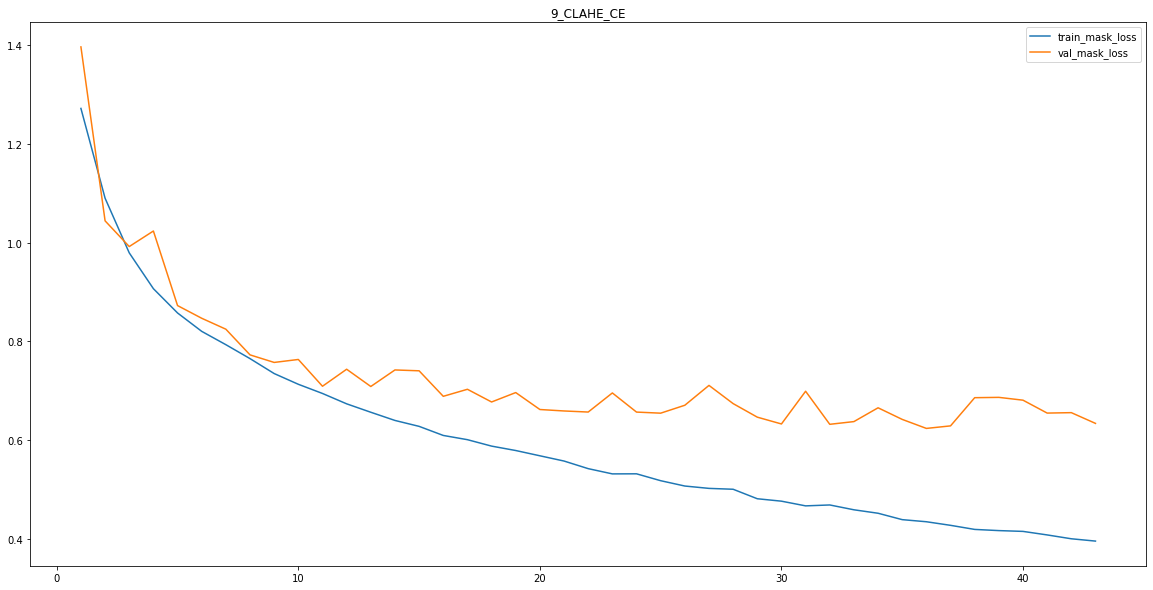

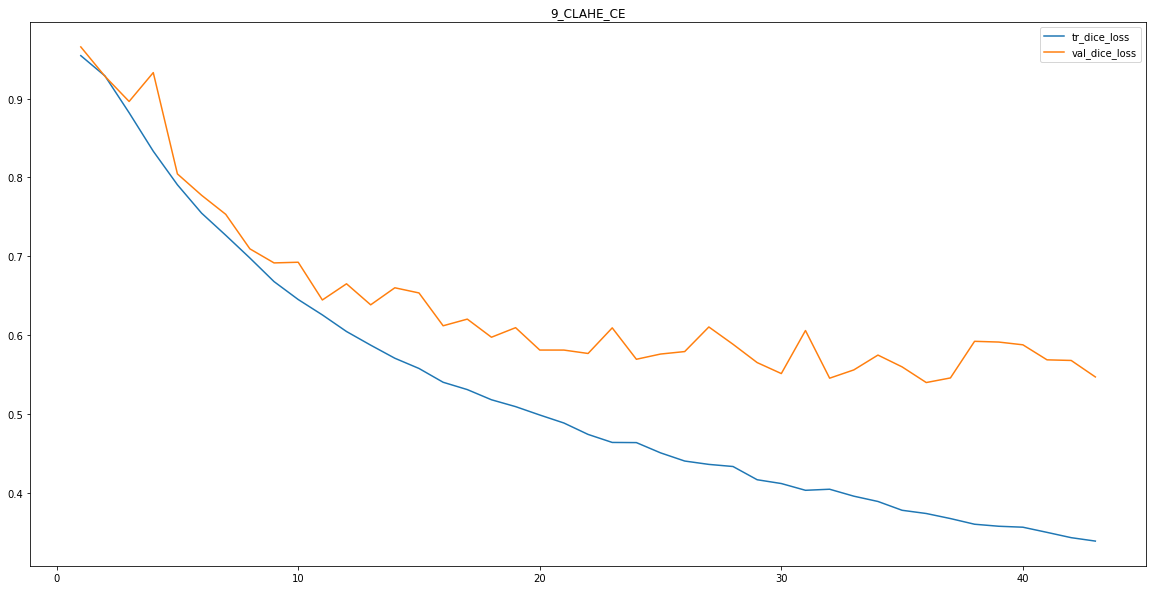

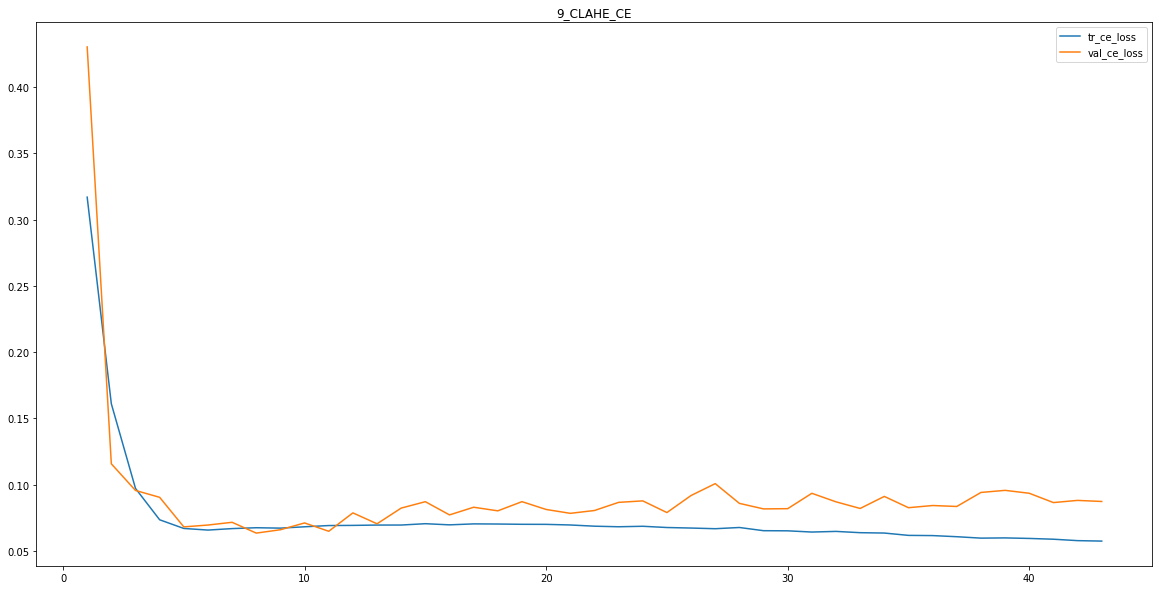

In [7]:
# history = parse_history_text('history/one_mask/New/9_CLAHE_CE_lr00001.txt')
file_name = '9_CLAHE_CE'
history = parse_history_text_CE(f'history/one_mask/New/{file_name}.txt')

plt.figure(figsize=(20, 10))

plt.plot(history['epoch'], history['train_mask_loss'], label='train_mask_loss')
plt.plot(history['epoch'], history['val_mask_loss'], label='val_mask_loss')

plt.title(f'{file_name}')
plt.legend()
plt.show()

plt.figure(figsize=(20, 10))

plt.plot(history['epoch'], history['tr_dice_loss'], label='tr_dice_loss')
plt.plot(history['epoch'], history['val_dice_loss'], label='val_dice_loss')

plt.title(f'{file_name}')
plt.legend()
plt.show()

plt.figure(figsize=(20, 10))

plt.plot(history['epoch'], history['tr_ce_loss'], label='tr_ce_loss')
plt.plot(history['epoch'], history['val_ce_loss'], label='val_ce_loss')

plt.title(f'{file_name}')
plt.legend()
plt.show()

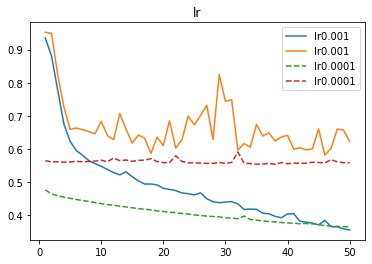

In [9]:
history = parse_history_text('history/one_mask/withoutCLAHE_withoutRecons_alpha00_lr0001.txt')

plt.plot(history['epoch'], history['train_mask_loss'], label='lr0.001')
plt.plot(history['epoch'], history['val_mask_loss'], label='lr0.001')


history = parse_history_text('history/one_mask/withoutCLAHE_withoutRecons_alpha00_lr00001.txt')

plt.plot(history['epoch'], history['train_mask_loss'], label='lr0.0001', linestyle='--')
plt.plot(history['epoch'], history['val_mask_loss'], label='lr0.0001', linestyle='--')

plt.title('lr')
plt.legend()
plt.show()

# 평가지표

In [10]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import roc_auc_score, average_precision_score

In [11]:
def dice_coefficient(y_true, y_pred, smooth=1e-7):
    intersection = tf.reduce_sum(y_true * y_pred)  # 교집합 계산
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)  # 합집합 계산
    return (2. * intersection + smooth) / (union + smooth)

def mean_absolute_error(y_true, y_pred):
    return tf.reduce_mean(tf.abs(y_true - y_pred))  # MAE 계산

def calculate_iou(y_true, y_pred, threshold=0.5):
    y_pred = tf.cast(y_pred > threshold, tf.float32)  # 예측값 이진화
    intersection = tf.reduce_sum(y_true * y_pred)  # 교집합 계산
    union = tf.reduce_sum(tf.cast(y_true + y_pred > threshold, tf.float32))  # 합집합 계산
    return intersection / (union + 1e-7)  # IoU 계산, 1e-7 추가로 나눗셈 by zero 방지

# 세그멘테이션 결과를 평가하는 함수
# y_true와 y_pred는 [batch_size, height, width, channels] 형식으로 가정
def evaluate_segmentation(y_true, y_pred):
    # 배열을 평평하게 만든다.
    y_true_flat = tf.reshape(y_true, [-1])
    y_pred_flat = tf.reshape(y_pred, [-1])

    # Dice 계수 계산
    dice = dice_coefficient(y_true_flat, y_pred_flat)

    # IoU (Intersection over Union) 계산
    iou = calculate_iou(y_true_flat, y_pred_flat)

    # AUC-ROC 계산
    roc_auc = roc_auc_score(y_true_flat, y_pred_flat)

    # AUC-PR 계산
    pr_auc = average_precision_score(y_true_flat, y_pred_flat)

    # MAE 계산
    mae = mean_absolute_error(y_true_flat, y_pred_flat)

    return dice, iou, roc_auc, pr_auc, mae


In [12]:
# preds[1]은 예측된 세그멘테이션 마스크를 가정합니다.
# targets는 실제 세그멘테이션 마스크입니다.
preds = model(inputs[0])
dice, iou, roc_auc, pr_auc, mae = evaluate_segmentation(targets, preds[1])

# 결과 출력
print("Dice Coefficient:", dice)
print("IoU (Intersection over Union):", iou)
print("ROC AUC Score:", roc_auc)
print("PR AUC Score:", pr_auc)
print("Mean Absolute Error:", mae)

NameError: name 'inputs' is not defined